Initial test of LSTM range prediction, based off: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

In [1]:
# Version History:

#------------------------------------------------------------------------------#
#                                                                              #
# v1.0.0 - Testing code to predict range of values using vapor fraction.       #
# v1.0.1 - Testing the range itself by editing vector size.                    #
# v1.0.2 - Working with output array to find more readable results.            #
#          Adding MSE for predictions vs. dataset with a function to do        #
#          automate along with plotting potential.                             #
# v1.0.3 - Cleaning up the code with a focus on a single preliminary result.   #
#          Added "padding" to actually line up results.                        #
# v1.0.4 - Running code with several vector sizes to analyze error growth.     #
# v1.0.5 - Editing figures/results presentation per Dr. Hu's comments.         #
#                                                                              #
#------------------------------------------------------------------------------#

In [2]:
import os
import glob
import re
import pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy
from numpy import array
import math
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


Function to split dataset into vectors.

In [3]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Finding the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # Checking if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # Gather input and output parts of pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [4]:
def lstm_error(dataset, n_steps_in, n_steps_out, n_features, plot):
    X_dataset, y_dataset = split_sequence(dataset, n_steps_in, n_steps_out)
    y_dataset = y_dataset.reshape((y_dataset.shape[0], y_dataset.shape[1]))
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu', return_sequences=False))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_dataset, y_dataset, epochs=20, verbose=0)
    model_name = "vapor_fraction_model_" + str(n_steps_in) + "in_" + str(n_steps_out) + "out.h5"
    model.save(model_name)
    
    y_dataset_hat = model.predict(X_dataset)
    X_plot = X_dataset.reshape(X_dataset.shape[0], X_dataset.shape[1])
    
    X_plot_1 = []
    for i in range(len(dataset) - n_steps_in - n_steps_out + 1):
        X_plot_1.append(X_plot[i][0])
              
    y_dataset_hat_1 = []
    for i in range(len(dataset) - n_steps_in - n_steps_out + 1):
        y_dataset_hat_1.append(y_dataset_hat[i][0])
        
    cut = n_steps_in-1
    dataset_cut = dataset[cut:-n_steps_out]
    
    if plot==True:
        plt.figure(figsize=(15,7))
        plt.plot(y_dataset_hat_1, label='prediction');
        plt.plot(dataset_cut, label='original');
        plt.legend();
        plot_title = "Vapor Fraction Prediction, Vector Size (Period) = " + str(n_steps_in)
        plt.title(plot_title)
        plt.xlabel('timestep');
        plt.ylabel('vapor fraction');
        plot_name = "figures\\prediction_overlay_" + str(n_steps_in) + "in_" + str(n_steps_out) + "out" + ".png"
        #plt.savefig(plot_name)
    elif plot==False:
        pass
    
    error = math.sqrt(mean_squared_error(y_dataset_hat_1, dataset_cut))
    print("{:.2f}".format(error*100) + "%")
    
    return error

In [5]:
def load_model_results(dataset, n_steps_in, n_steps_out, model_file, plot):
    model = load_model(model_file)
    
    X_dataset, y_dataset = split_sequence(dataset, n_steps_in, n_steps_out)
    y_dataset = y_dataset.reshape((y_dataset.shape[0], y_dataset.shape[1]))  
    
    y_dataset_hat = model.predict(X_dataset)
    
    y_dataset_hat_1 = []
    for i in range(len(dataset) - n_steps_in - n_steps_out + 1):
        y_dataset_hat_1.append(y_dataset_hat[i][0])
        
    cut = n_steps_in-1
    dataset_cut = dataset[cut:-n_steps_out]
    
    if plot==True:
        plt.figure(figsize=(20,7))
        plt.rcParams["font.family"] = "Arial"
        plt.rcParams.update({'font.size': 22})
        plt.rcParams['axes.xmargin'] = 0
        plt.plot(dataset_cut, label='Original', color='blue');
        plt.plot(y_dataset_hat_1, label='Prediction', color='red', linestyle='--');
        plt.legend();
        plot_title = "Vapor Fraction Prediction, " + str(n_steps_in) + " In, " + str(n_steps_out) + " Out"
        plt.title(plot_title)
        plt.xlabel('Timestep',fontsize='24');
        plt.ylabel('Vapor Fraction',fontsize='24');
        plot_name = "figures\\prediction_overlay_" + str(n_steps_in) + "in_" + str(n_steps_out) + "out_edited.png"
        plt.savefig(plot_name)
    elif plot==False:
        pass
    
    error = math.sqrt(mean_squared_error(y_dataset_hat_1, dataset_cut))
    print("{:.2f}".format(error*100) + "%")
    
    return error

In [6]:
def save_to_txt(dataset, n_steps_in, n_steps_out, model_file):
    model = load_model(model_file)
    
    X_dataset, y_dataset = split_sequence(dataset, n_steps_in, n_steps_out)
    y_dataset = y_dataset.reshape((y_dataset.shape[0], y_dataset.shape[1]))  
    
    y_dataset_hat = model.predict(X_dataset)
    
    y_dataset_hat_1 = []
    for i in range(len(dataset) - n_steps_in - n_steps_out + 1):
        y_dataset_hat_1.append(y_dataset_hat[i][0])
        
    cut = n_steps_in-1
    dataset_cut = dataset[cut:-n_steps_out]
    
    filename = "prediction_and_original_data_" + str(n_steps_in) + "in_" + str(n_steps_out) + "out.txt"
    
    data = []
    for i in range(len(y_dataset_hat_1)):
        val = []
        val.append(y_dataset_hat_1[i])
        val.append(dataset_cut[i])
        data.append(val)
    
    numpy.savetxt(filename, data, newline="\n")

In [7]:
# Fix random seed for reproducibility
numpy.random.seed(7)

# Load the dataset
dataset = pandas.read_csv('vapor_fraction.txt', sep='\t', header=None, usecols=[1],
                          engine='python')
dataset = dataset.values
dataset = dataset.astype('float32')

In [8]:
# Loading and sorting filenames to list
files = glob.glob('models\\*.h5')
model_array = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[0]))

In [9]:
for i in range(len(model_array)):
    print(i, model_array[i])

0 models\vapor_fraction_model_1in_1out.h5
1 models\vapor_fraction_model_2in_1out.h5
2 models\vapor_fraction_model_5in_5out.h5
3 models\vapor_fraction_model_10in_10out.h5
4 models\vapor_fraction_model_10in_5out.h5
5 models\vapor_fraction_model_20in_10out.h5
6 models\vapor_fraction_model_20in_20out.h5
7 models\vapor_fraction_model_50in_25out.h5
8 models\vapor_fraction_model_50in_50out.h5
9 models\vapor_fraction_model_100in_100out.h5
10 models\vapor_fraction_model_100in_50out.h5
11 models\vapor_fraction_model_150in_150out.h5
12 models\vapor_fraction_model_200in_100out.h5
13 models\vapor_fraction_model_200in_200out.h5
14 models\vapor_fraction_model_250in_125out.h5
15 models\vapor_fraction_model_250in_250out.h5
16 models\vapor_fraction_model_300in_300out.h5


In [10]:
# Defining the indices for N, N and 2N, N
N_N_idx = [0,2,3,6,8,9,11,13,15,16]
N2_N_idx = [1,4,5,7,10,12,14]

0.54%
1.06%
1.85%
1.58%
2.35%
3.24%
5.45%
7.37%
0.89%
1.20%
1.44%
2.10%
3.51%
3.80%
3.04%


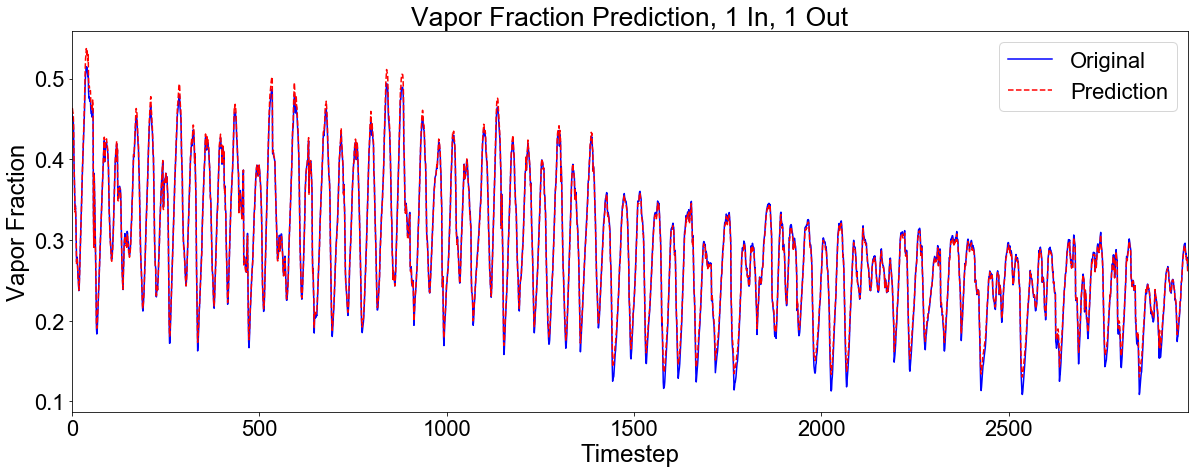

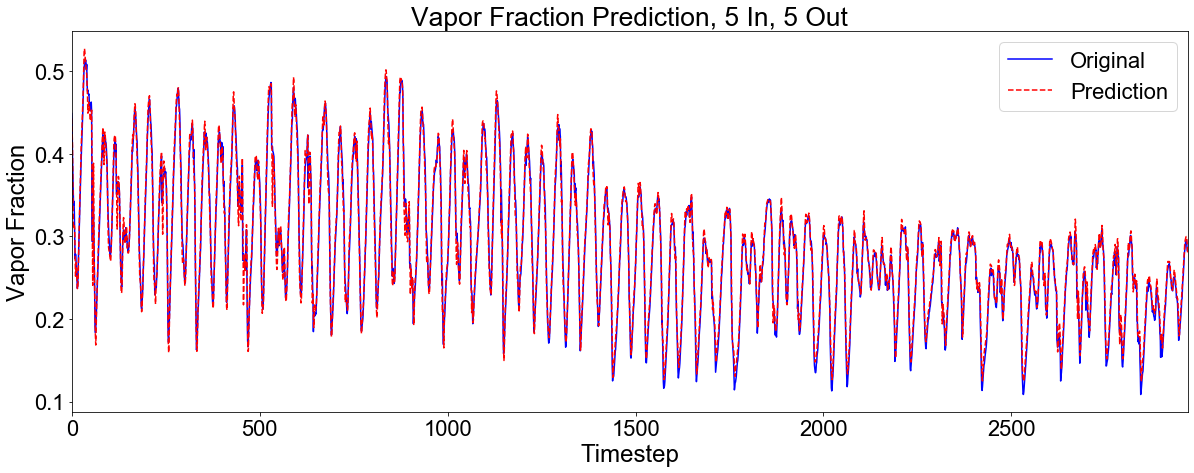

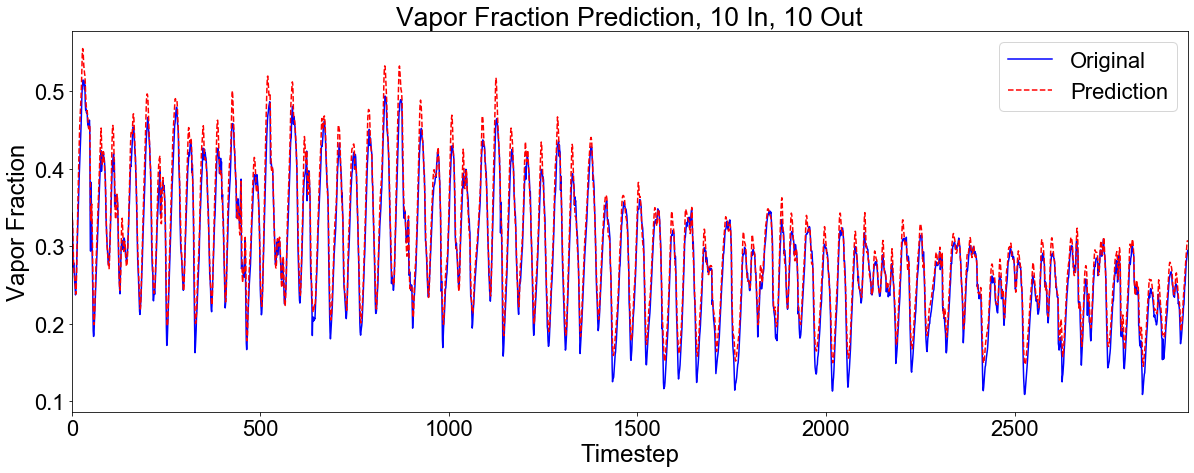

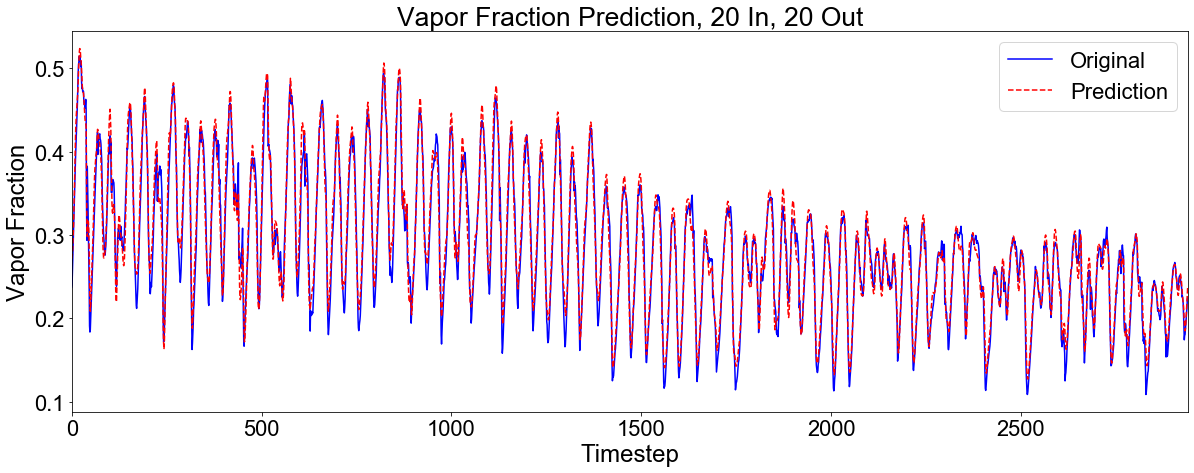

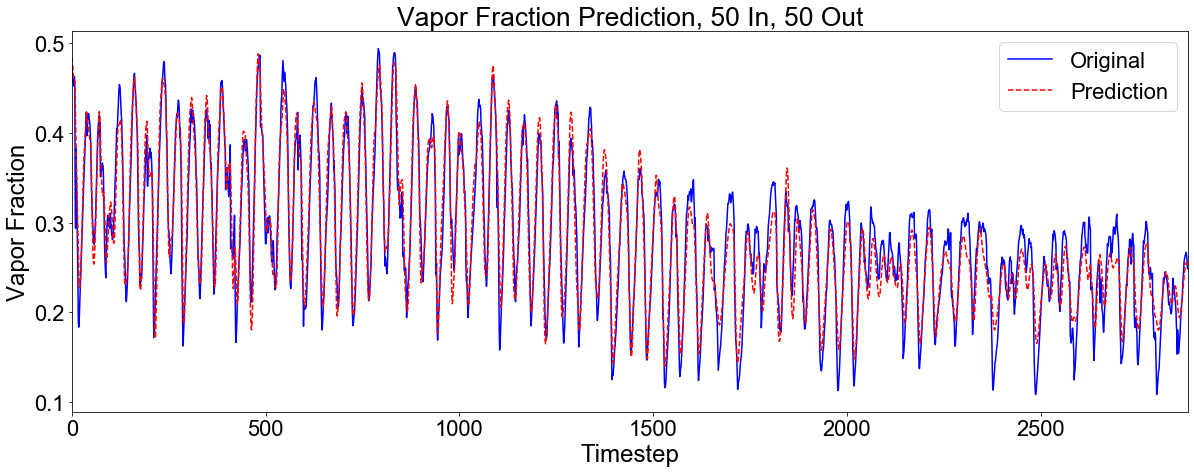

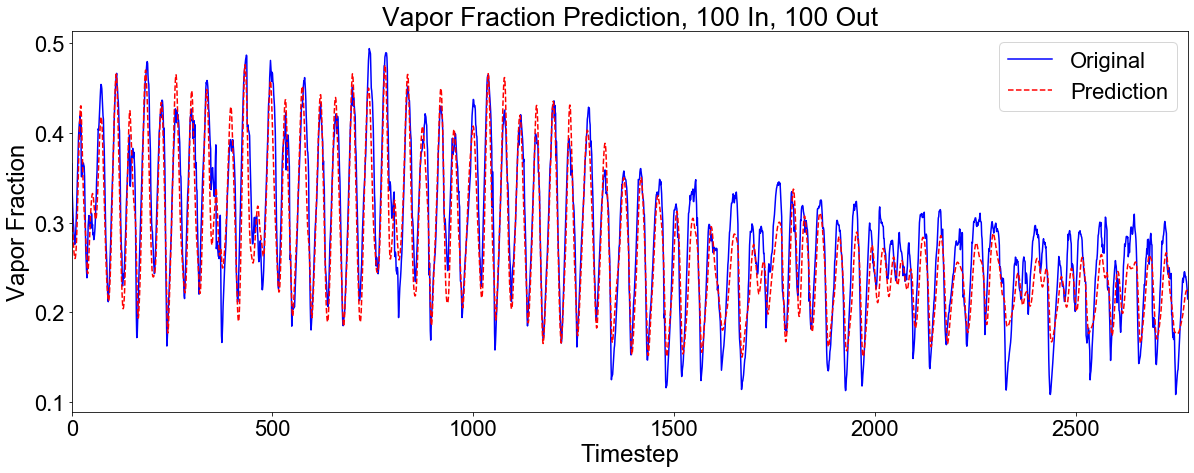

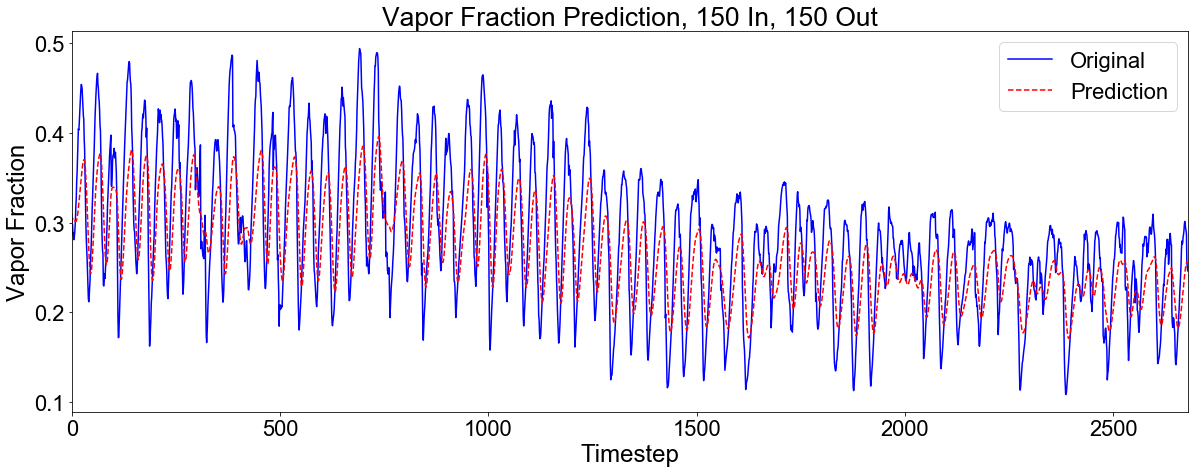

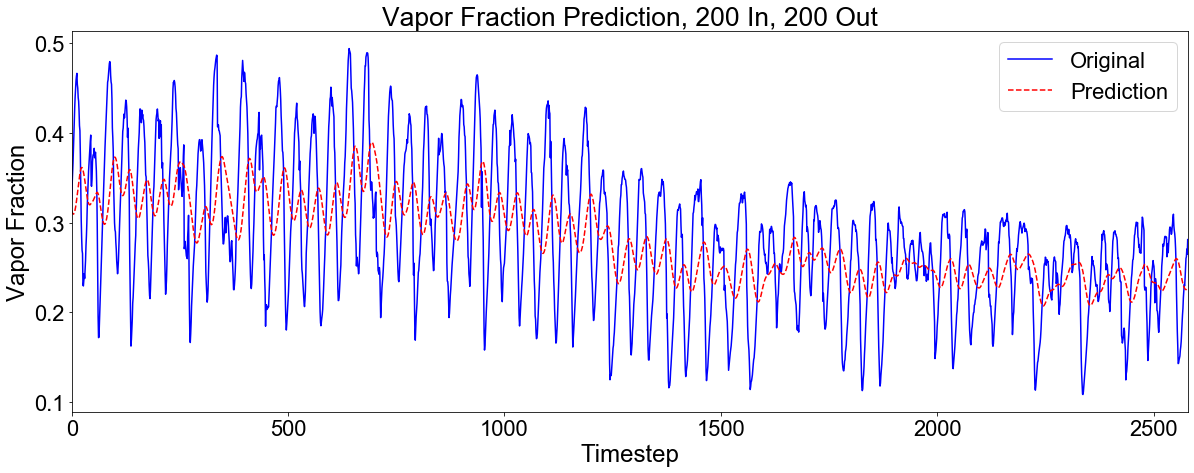

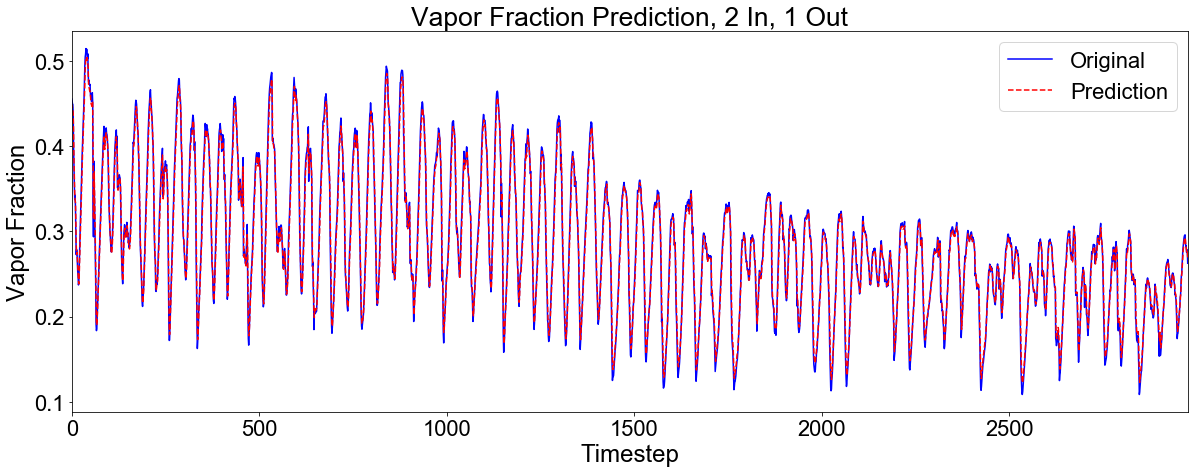

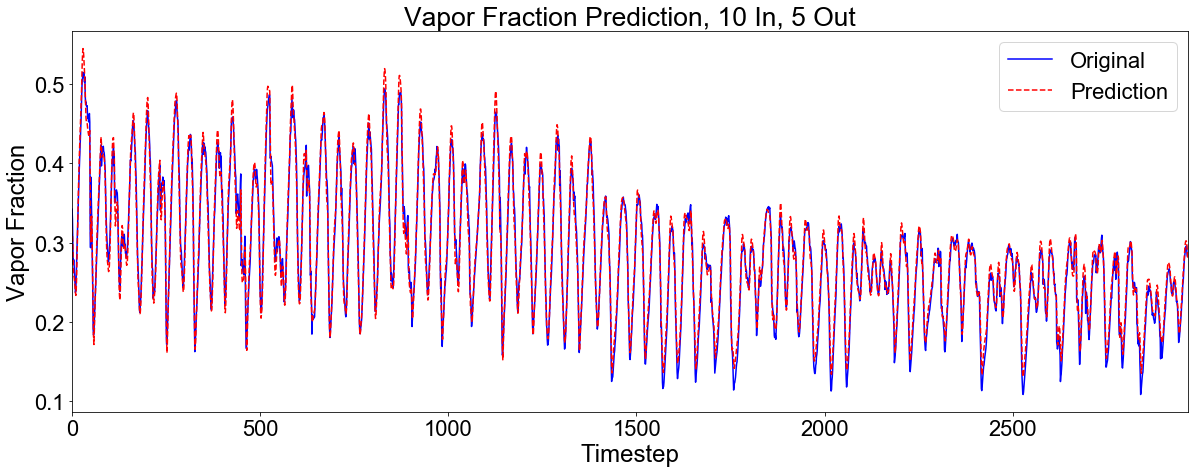

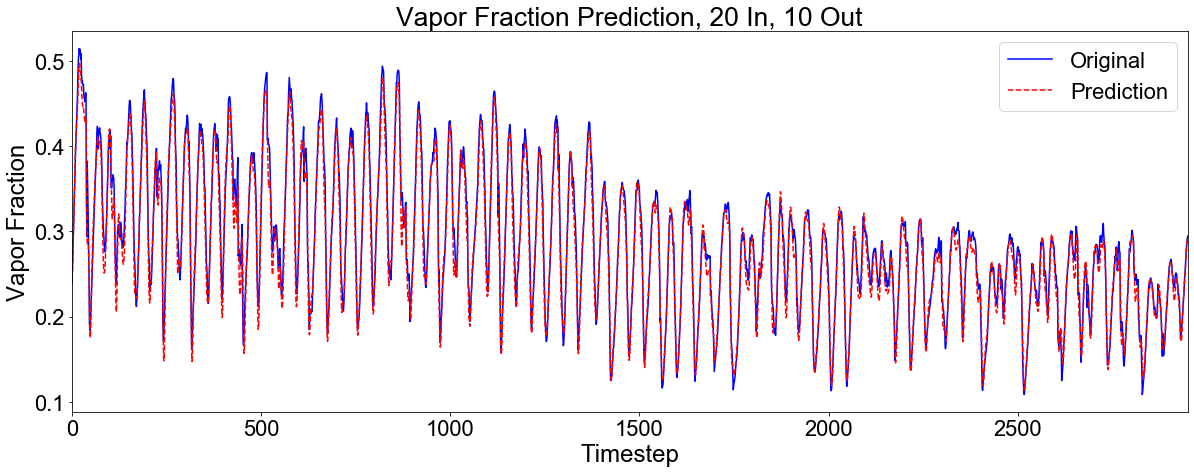

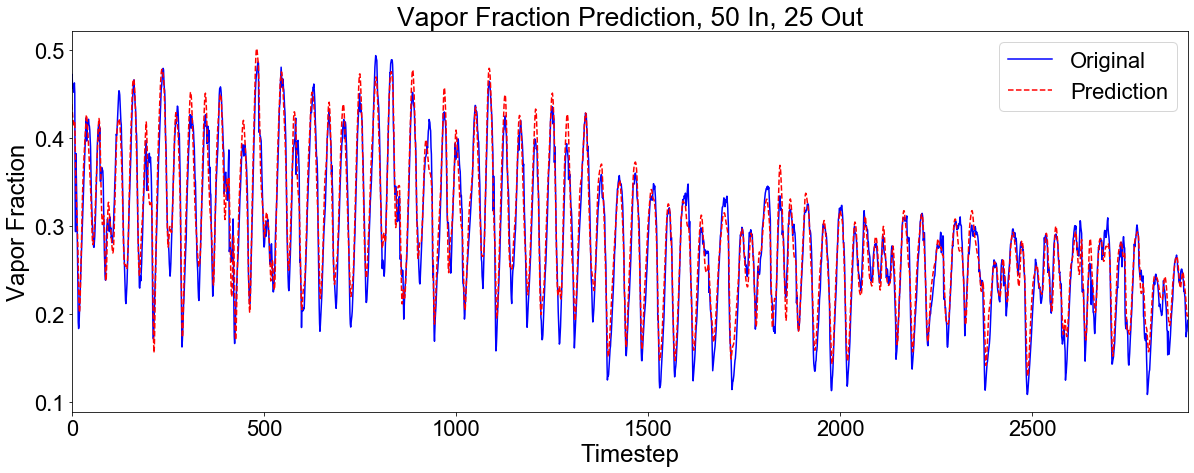

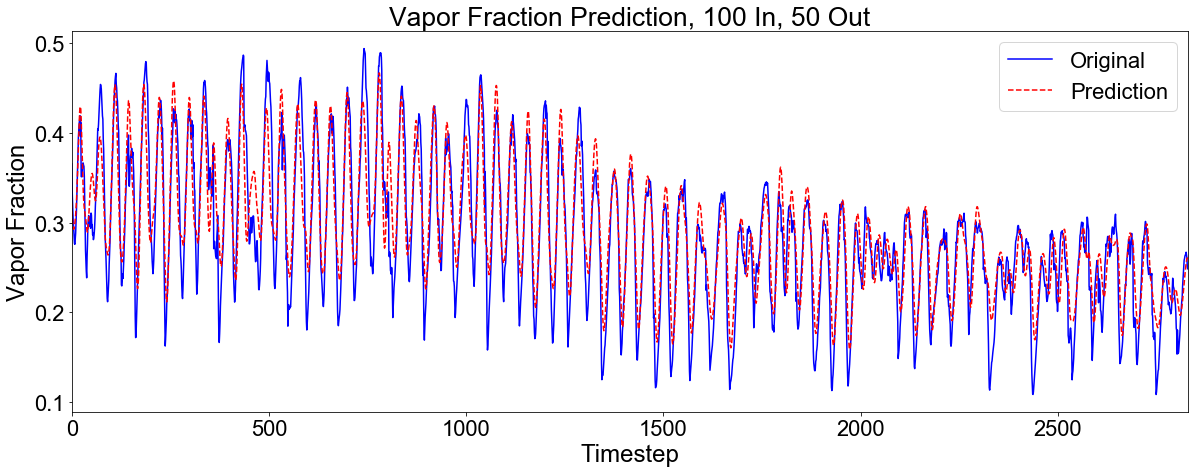

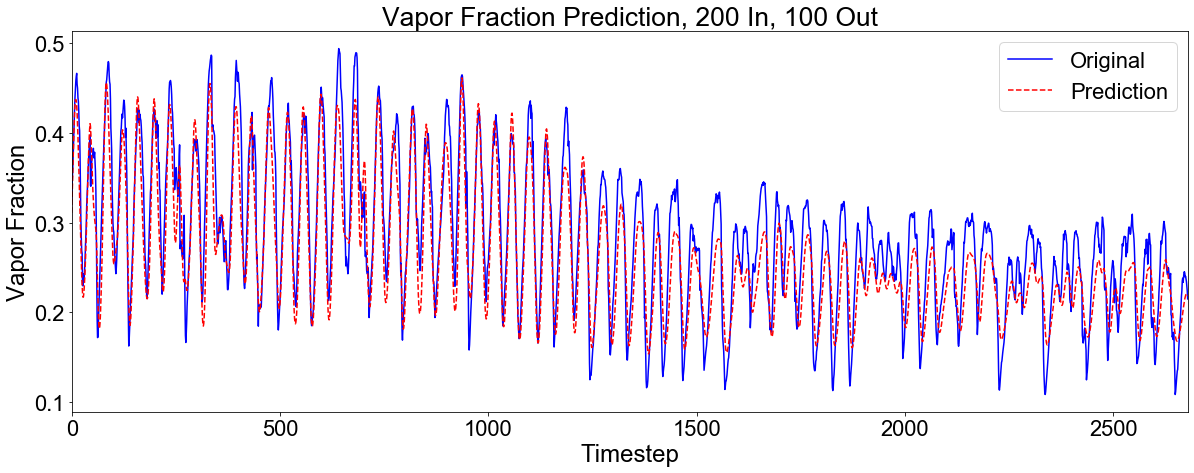

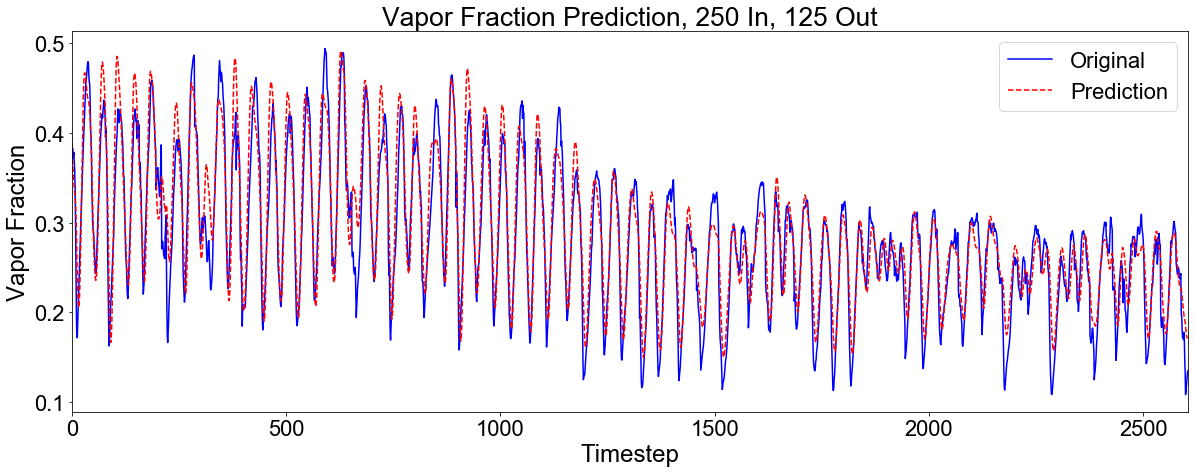

In [11]:
period = [1, 5, 10, 20, 50, 100, 150, 200]
period2 = [1, 5, 10, 25, 50, 100, 125]
error_array = []
error2_array = []

# Loop for N in, N out
for i in range(len(period)):
    #print(period[i], model_array[N_N_idx[i]])
    size = period[i]
    filename = model_array[N_N_idx[i]]
    error_array.append(load_model_results(dataset, size, size, filename, True))

# Loop for 2N in, N out
for i in range(len(period2)):
    #print(period[i], model_array[N_N_idx[i]])
    size = period2[i]
    filename = model_array[N2_N_idx[i]]
    error2_array.append(load_model_results(dataset, 2*size, size, filename, True))

In [12]:
save_to_txt(dataset, 50, 50, model_array[8])
save_to_txt(dataset, 100, 50, model_array[10])
print("All done!")

All done!


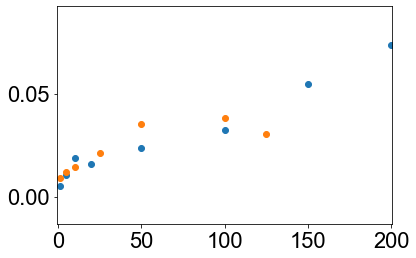

In [13]:
plt.scatter(period, error_array)
plt.scatter(period2, error2_array)

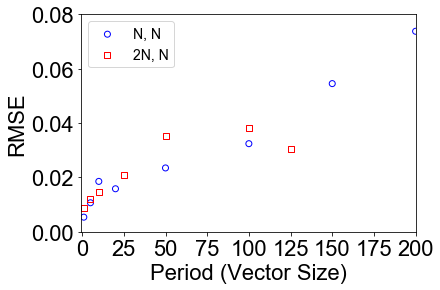

In [14]:
fig, ax = plt.subplots(1,1)
ax.scatter(period, error_array, color='blue', label='N, N', marker='o', facecolor='none')
ax.scatter(period2, error2_array, color='red', label='2N, N', marker='s', facecolor='none')
ax.set_ylim([0.00,0.08])
loc = plticker.MultipleLocator(base=25) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=0.02)
ax.yaxis.set_major_locator(loc)
ax.margins(x=0, y=-0.0879)
ax.legend(fontsize='14', loc='upper left')
ax.set_xlabel('Period (Vector Size)');
ax.set_ylabel('RMSE');
#ax.set_title('Square Root of MSE vs. Period (Vector Size)');
#fig.savefig('figures\\RMSE_period_2N_and_N.png', bbox_inches='tight')

In [15]:
test = [1, 2, 3, 4]
test2 = [6, 7, 8, 9]
data = []
for i in range(len(test)):
    val = []
    val.append(test[i])
    val.append(test2[i])
    data.append(val)
#numpy.savetxt("text.txt", data, newline='\n')

In [16]:
#CONSIDER MAKING SUBDIRECTORY FOR IMAGES AND MODELS